In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_ETE_overall = pd.read_csv('/home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/End-To-End/search_qna/Evaluation/ETE_overall_accuracy.csv')
df_ETE_case = pd.read_csv('/home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/End-To-End/search_qna/Evaluation/ETE_case_level_accuracy.csv')
df_RAG_overall = pd.read_csv('/home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/RAG/Evaluation/RAG_overall_accuracy.csv')
df_RAG_case = pd.read_csv('/home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/RAG/Evaluation/RAG_case_level_accuracy.csv')
df_top1_overall = pd.read_csv('/home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/top1/Evaluation/top1_overall_accuracy.csv')
df_top1_case = pd.read_csv('/home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/top1/Evaluation/top1_case_level_accuracy.csv')

In [3]:
df_ETE_case["method"] = "ETE"
df_top1_case["method"] = "SDR"
df_RAG_case["method"] = "RAG"
combined_case_data = pd.concat([df_ETE_case, df_top1_case, df_RAG_case], ignore_index=True)

In [4]:
methods = ["ETE", "SDR", "RAG"]
means = [
    df_ETE_overall["mean_accuracy_all_cases"].iloc[0],
    df_top1_overall["mean_accuracy_all_cases"].iloc[0],
    df_RAG_overall["mean_accuracy_all_cases"].iloc[0]
]
stds = [
    df_ETE_overall["std_accuracy_all_cases"].iloc[0],
    df_top1_overall["std_accuracy_all_cases"].iloc[0],
    df_RAG_overall["std_accuracy_all_cases"].iloc[0]
]

In [5]:
colors = ["#E69F00", "#56B4E9", "#009E73"]

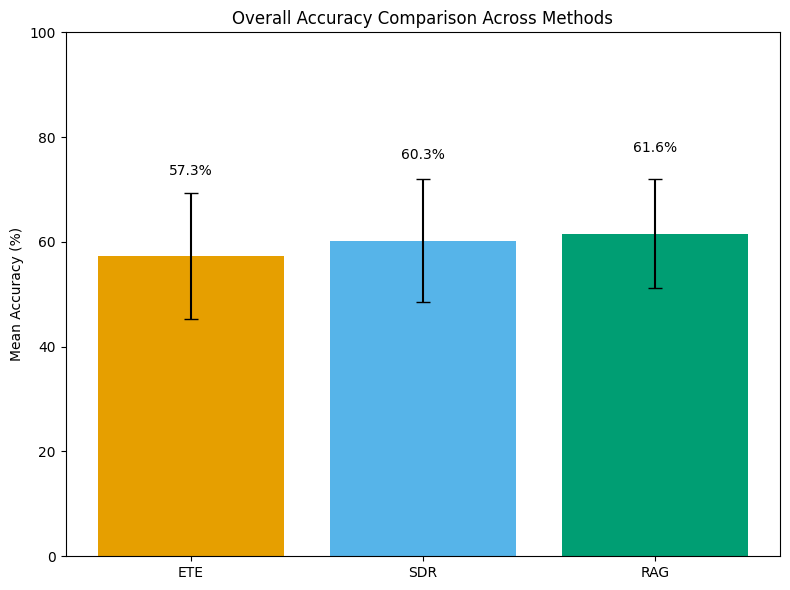

In [12]:
plt.figure(figsize=(8, 6))
bars = plt.bar(methods, means, yerr=stds, capsize=5, color=colors)
plt.ylabel("Mean Accuracy (%)")
plt.title("Overall Accuracy Comparison Across Methods")
plt.ylim(0, 100)
for bar, mean in zip(bars, means):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 15,
             f"{mean:.1f}%", ha='center', va='bottom')
plt.tight_layout()
plt.savefig("/home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/overall_accuracy.png")
plt.show()

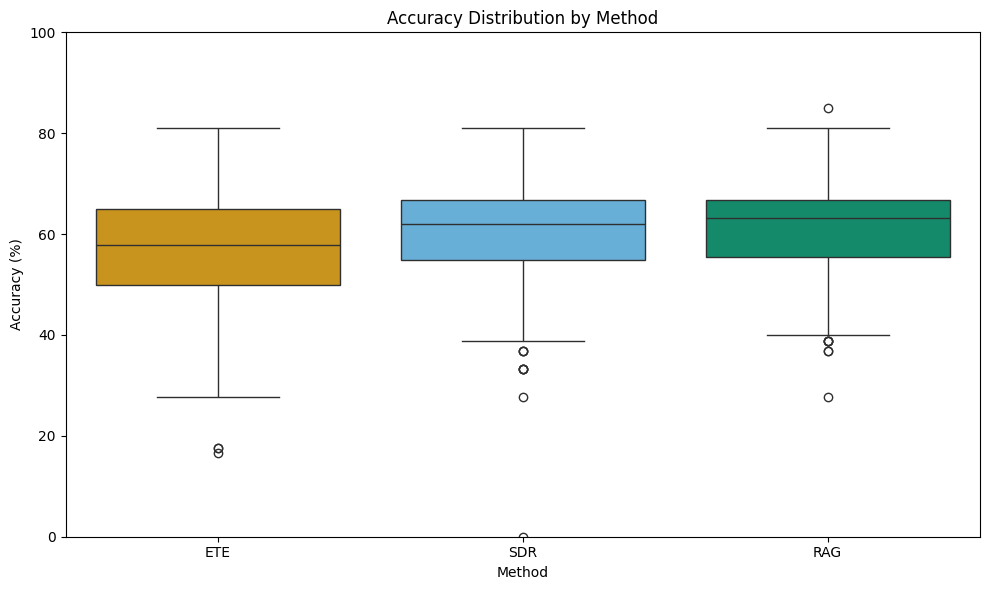

In [9]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="method", y="accuracy", hue="method", data=combined_case_data, palette=colors, legend=False)
plt.title("Accuracy Distribution by Method")
plt.xlabel("Method")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.tight_layout()
plt.savefig("/home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/case_level_boxplot.png")
plt.show()

In [54]:
root_dir = "/home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA"
method_folders = ["End-To-End", "RAG", "top1"]

all_dfs = []

for method in method_folders:
    # 경로 및 파일명 처리
    if method == "End-To-End":
        method_path = os.path.join(root_dir, method, "search_qna")
        filename = "ETE_evaluation_results.csv"
    else:
        method_path = os.path.join(root_dir, method)
        filename = f"{method}_evaluation_results.csv"

    if not os.path.isdir(method_path):
        print(f"🚫 폴더 없음: {method_path}")
        continue

    for combo_folder in os.listdir(method_path):
        combo_path = os.path.join(method_path, combo_folder)
        if not os.path.isdir(combo_path):
            continue

        try:
            retrieval_model, qna_model = combo_folder.split("_")
        except ValueError:
            print(f"⚠️ 폴더명 오류: {combo_folder}")
            continue

        csv_path = os.path.join(combo_path, filename)
        if not os.path.isfile(csv_path):
            print(f"❌ 파일 없음: {csv_path}")
            continue

        try:
            df = pd.read_csv(csv_path)

            # ✅ top1일 경우: 컬럼명 통일
            if method == "top1":
                df = df.rename(columns={"question_id": "Question", "correct": "Score"})

            # 정보 추가
            df["method"] = method
            df["retrieval_model"] = retrieval_model
            df["qna_model"] = qna_model

            all_dfs.append(df)
        except Exception as e:
            print(f"⚠️ 파일 읽기 오류: {csv_path}\n{e}")

# 병합 및 저장
if all_dfs:
    merged_df = pd.concat(all_dfs, ignore_index=True)
    save_path = os.path.join(root_dir, "LLM_QnA_Merged_Evaluation.csv")
    merged_df.to_csv(save_path, index=False)
    print(f"✅ 저장 완료: {save_path}")
else:
    print("❌ 병합할 데이터가 없습니다.")

⚠️ 폴더명 오류: Evaluation
⚠️ 폴더명 오류: Evaluation
⚠️ 폴더명 오류: Evaluation
✅ 저장 완료: /home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/LLM_QnA_Merged_Evaluation.csv


In [55]:
df = pd.read_csv("/home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/LLM_QnA_Merged_Evaluation.csv")
df.tail(1)

,Case,Question,Predicted,Gold,Score,method,retrieval_model,qna_model
10811,Case16,TOTAL,Correct: 13,Incorrect: 8,Accuracy: 61.90%,top1,perplexity,perplexity


In [57]:
df_RAG_case["method"] = "RAG"
df_ETE_case["method"] = "End-To-End"
df_top1_case["method"] = "top1"

for df_case in [df_RAG_case, df_ETE_case, df_top1_case]:
    df_case.rename(columns={"case_id": "Case"}, inplace=True)

case_level_match_df = pd.concat([df_RAG_case, df_ETE_case, df_top1_case], ignore_index=True)

df_with_match = df.merge(
    case_level_match_df[["Case", "retrieval_model", "qna_model", "method", "match"]],
    on=["Case", "retrieval_model", "qna_model", "method"],
    how="left"
)

df_with_match.to_csv(save_path, index=False)

In [58]:
df_clean = df_with_match[
    (~df_with_match["Predicted"].astype(str).str.contains("Correct:|Incorrect:", na=False)) &
    (~df_with_match["Gold"].astype(str).str.contains("Correct:|Incorrect:", na=False))
].copy()
df_clean["Score"] = pd.to_numeric(df_clean["Score"], errors="coerce")
print(df_clean[df_clean["method"] == "top1"]["Score"].describe())

count    3337.000000
mean        0.606832
std         0.488527
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: Score, dtype: float64


In [59]:
df_clean.head()

,Case,Question,Predicted,Gold,Score,method,retrieval_model,qna_model,match
0,Case10,Q0,Whole Exome Sequencing (WES),Whole Exome Sequencing (WES),1,End-To-End,chatgpt,perplexity,False
1,Case10,Q1,Not specified,Yes,0,End-To-End,chatgpt,perplexity,False
2,Case10,Q2,Not specified,No,0,End-To-End,chatgpt,perplexity,False
3,Case10,Q3,No,No,1,End-To-End,chatgpt,perplexity,False
4,Case10,Q4,No,Yes,0,End-To-End,chatgpt,perplexity,False


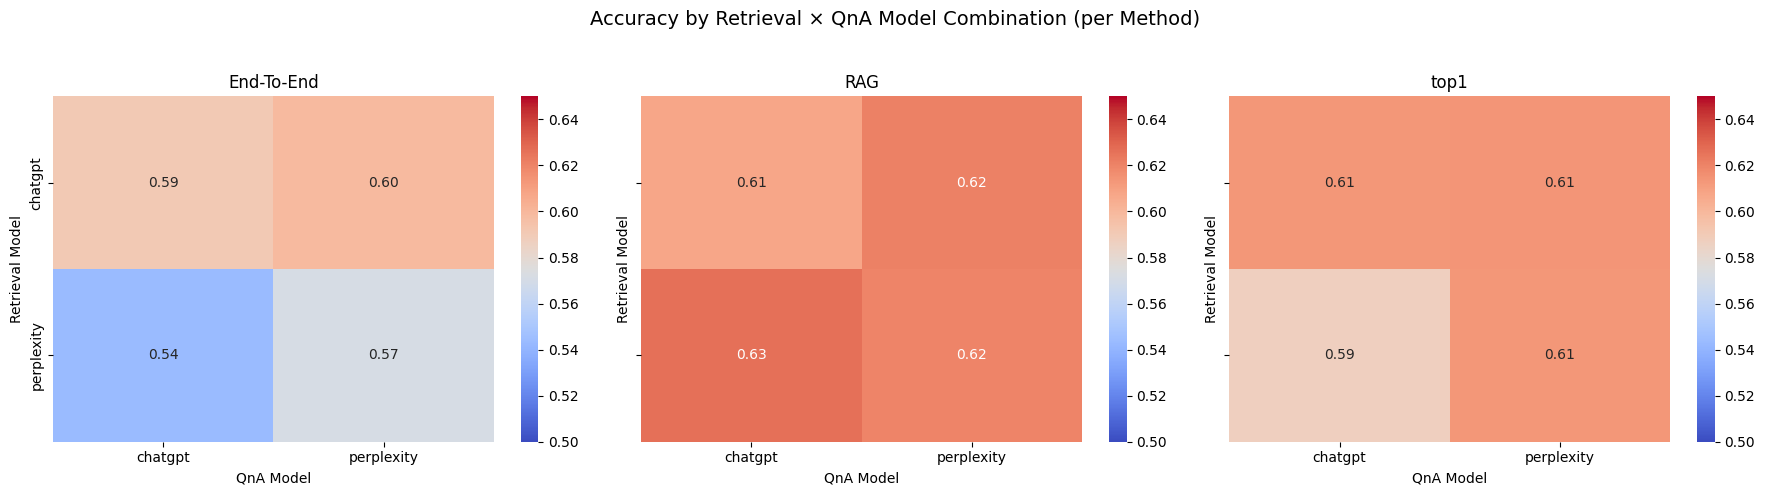

In [50]:
# Step 1: Score 컬럼을 숫자로 변환 (혹시 문자열로 되어 있으면)
df_clean["Score"] = pd.to_numeric(df_clean["Score"], errors="coerce")

# Step 2: 평균 정확도 계산
heatmap_data = df_clean.groupby(["method", "retrieval_model", "qna_model"])["Score"].mean().reset_index()

# Step 3: 각 방법론별로 pivot → heatmap 형태로 재구성
pivoted = {}
for method in heatmap_data["method"].unique():
    df_sub = heatmap_data[heatmap_data["method"] == method]
    pivoted[method] = df_sub.pivot(index="retrieval_model", columns="qna_model", values="Score")

# Step 4: Heatmap 그리기 (방법론별 subplot)
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
vmin = 0.50
vmax = 0.65

for ax, method in zip(axes, pivoted.keys()):
    sns.heatmap(
        pivoted[method],
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        cbar=True,
        vmin=vmin,
        vmax=vmax,
        ax=ax
    )
    ax.set_title(method)
    ax.set_xlabel("QnA Model")
    ax.set_ylabel("Retrieval Model")

plt.suptitle("Accuracy by Retrieval × QnA Model Combination (per Method)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

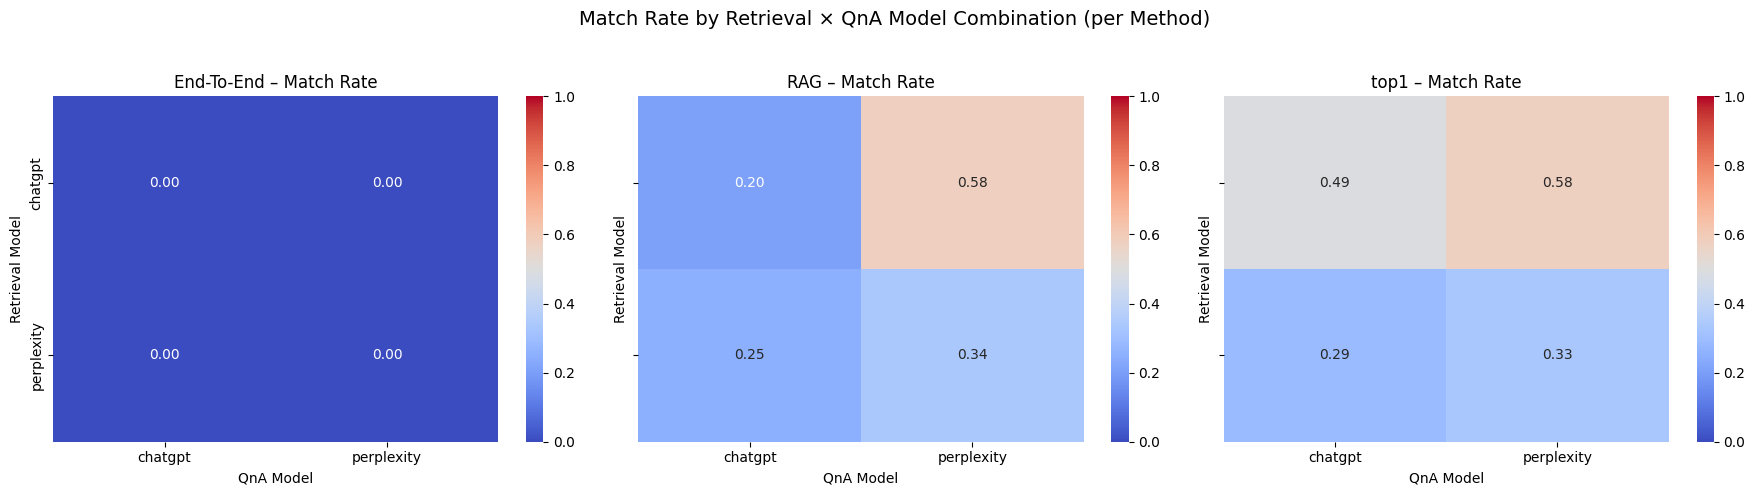

In [61]:
df_clean["match"] = df_clean["match"].astype(str).str.lower().map({"true": True, "false": False})
df_valid = df_clean[df_clean["match"].notna()].copy()

match_rate = (
    df_valid.groupby(["method", "retrieval_model", "qna_model"])["match"]
    .mean()
    .reset_index(name="match_rate")
)

pivoted_match = {
    method: match_rate[match_rate["method"] == method].pivot(
        index="retrieval_model", columns="qna_model", values="match_rate"
    )
    for method in match_rate["method"].unique()
}

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
vmin, vmax = 0.0, 1.0

for ax, method in zip(axes, pivoted_match.keys()):
    sns.heatmap(
        pivoted_match[method],
        annot=True,
        fmt=".2f",
        cmap="coolwarm", 
        cbar=True,
        vmin=vmin,
        vmax=vmax,
        ax=ax
    )
    ax.set_title(f"{method} – Match Rate")
    ax.set_xlabel("QnA Model")
    ax.set_ylabel("Retrieval Model")

plt.suptitle("Match Rate by Retrieval × QnA Model Combination (per Method)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

📊 Accuracy % (± StdErr):
- End-To-End | Match = False → 57.7% ± 0.8% (n=3414)
- RAG | Match = False → 59.5% ± 1.0% (n=2276)
- RAG | Match = True → 66.3% ± 1.3% (n=1263)
- top1 | Match = False → 57.0% ± 1.1% (n=1938)
- top1 | Match = True → 65.8% ± 1.3% (n=1399)


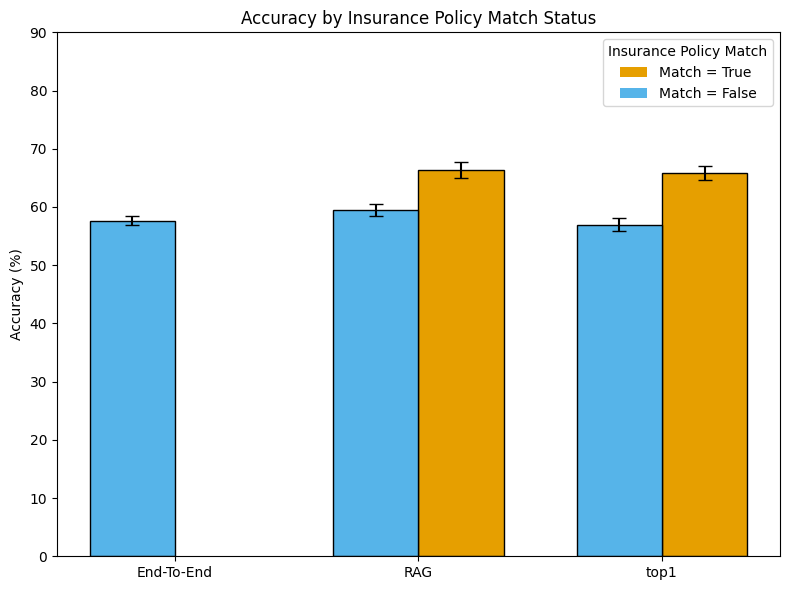

In [69]:
acc_grouped = (
    df_acc.groupby(["method", "match"])["correct"]
    .agg(["mean", "count"])
    .reset_index()
)
acc_grouped["stderr"] = np.sqrt((acc_grouped["mean"] * (1 - acc_grouped["mean"])) / acc_grouped["count"])
acc_grouped["accuracy_pct"] = acc_grouped["mean"] * 100
acc_grouped["stderr_pct"] = acc_grouped["stderr"] * 100

# 출력
print("📊 Accuracy % (± StdErr):")
for _, row in acc_grouped.iterrows():
    print(f"- {row['method']} | Match = {row['match']} → {row['accuracy_pct']:.1f}% ± {row['stderr_pct']:.1f}% (n={int(row['count'])})")

# 시각화
methods = ["End-To-End", "RAG", "top1"]
match_status = [True, False]  # True 먼저
bar_width = 0.35

# 사용자 정의 색상: True = 노란색, False = 파란색
match_colors = {True: "#E69F00", False: "#56B4E9"}  # color-blind friendly

positions, accs, stderrs, colors = [], [], [], []

for i, method in enumerate(methods):
    for j, match in enumerate(match_status):
        row = acc_grouped[(acc_grouped["method"] == method) & (acc_grouped["match"] == match)]
        if not row.empty:
            xpos = i + (bar_width/2 if match else -bar_width/2)
            positions.append(xpos)
            accs.append(row["accuracy_pct"].values[0])
            stderrs.append(row["stderr_pct"].values[0])
            colors.append(match_colors[match])

# 그리기
plt.figure(figsize=(8, 6))
bars = plt.bar(
    positions, accs, yerr=stderrs, capsize=5, width=bar_width,
    color=colors, edgecolor="black"
)

plt.xticks(ticks=range(len(methods)), labels=methods)
plt.ylim(0, 90)
plt.ylabel("Accuracy (%)")
plt.title("Accuracy by Insurance Policy Match Status")
plt.legend(
    [plt.Rectangle((0,0),1,1,fc=match_colors[True]),
     plt.Rectangle((0,0),1,1,fc=match_colors[False])],
    ["Match = True", "Match = False"],
    title="Insurance Policy Match"
)
plt.tight_layout()
plt.show()

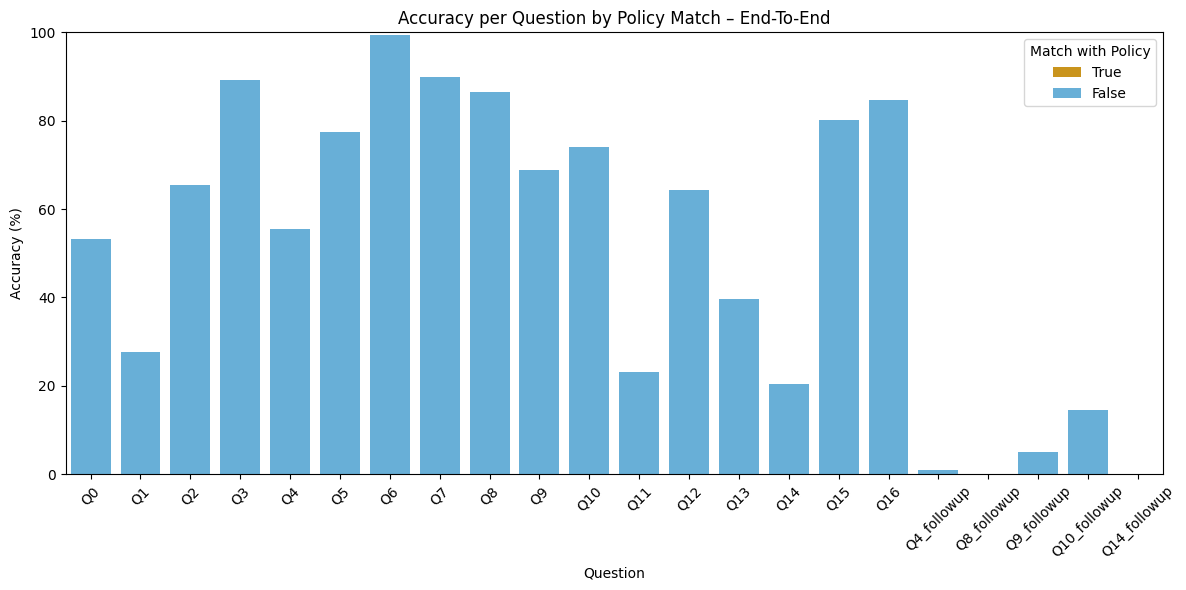

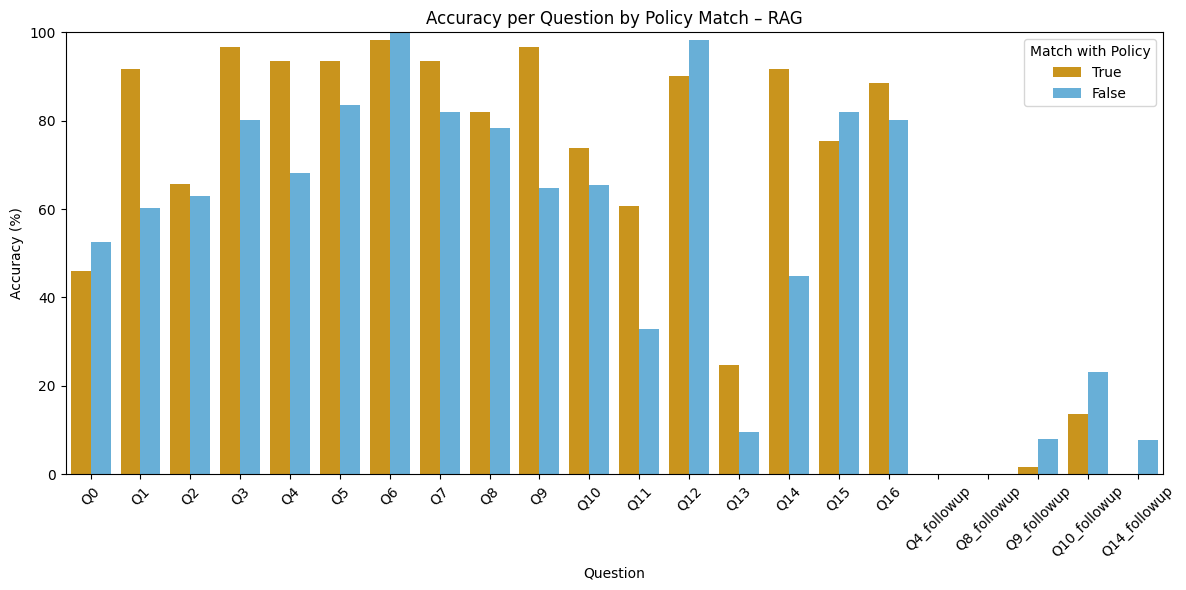

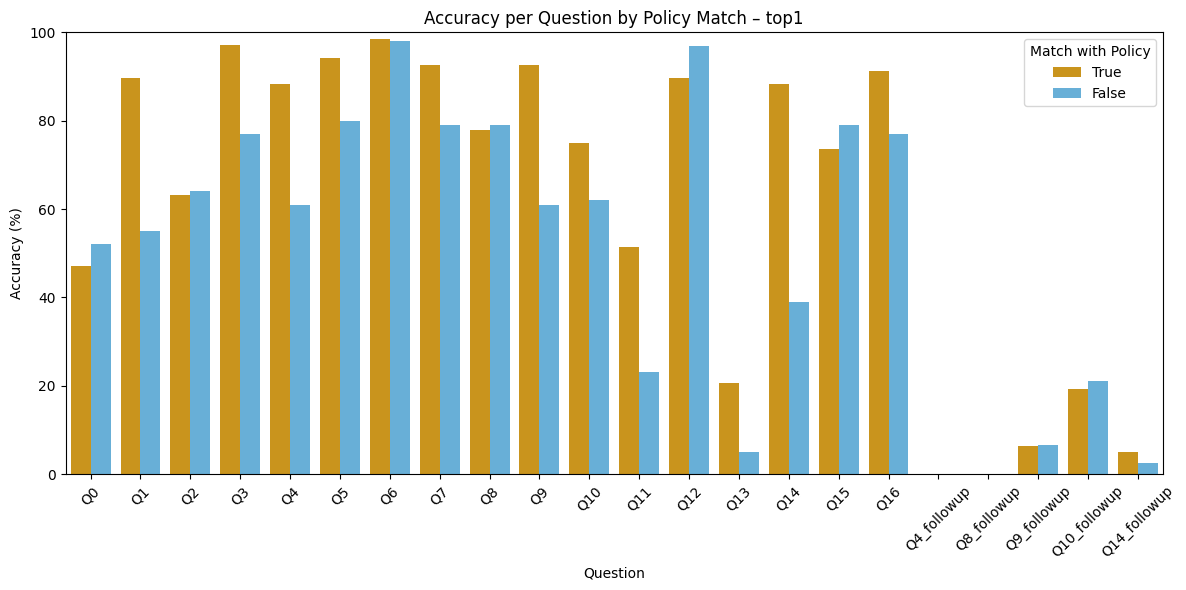

In [72]:
match_colors = {True: "#E69F00", False: "#56B4E9"}  # True: 노랑, False: 파랑
match_order = [True, False]
methods = ["End-To-End", "RAG", "top1"]

# 방법론별 질문별 Accuracy 시각화
for method in methods:
    df_method = df_clean[(df_clean["method"] == method) & (df_clean["Score"].notna())].copy()

    # Accuracy 계산
    df_method["correct"] = df_method["Score"] == 1
    question_level = (
        df_method
        .groupby(["Question", "match"])["correct"]
        .agg(["mean", "count"])
        .reset_index()
    )
    question_level["accuracy_pct"] = question_level["mean"] * 100

    # 질문 순서 정렬
    question_order = sorted(df_method["Question"].dropna().unique(), key=lambda x: (len(x), x))

    # 시각화
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=question_level,
        x="Question",
        y="accuracy_pct",
        hue="match",
        hue_order=match_order,
        order=question_order,
        palette=match_colors
    )
    plt.xticks(rotation=45)
    plt.ylabel("Accuracy (%)")
    plt.ylim(0, 100)
    plt.title(f"Accuracy per Question by Policy Match – {method}")
    plt.legend(title="Match with Policy")
    plt.tight_layout()
    plt.show()

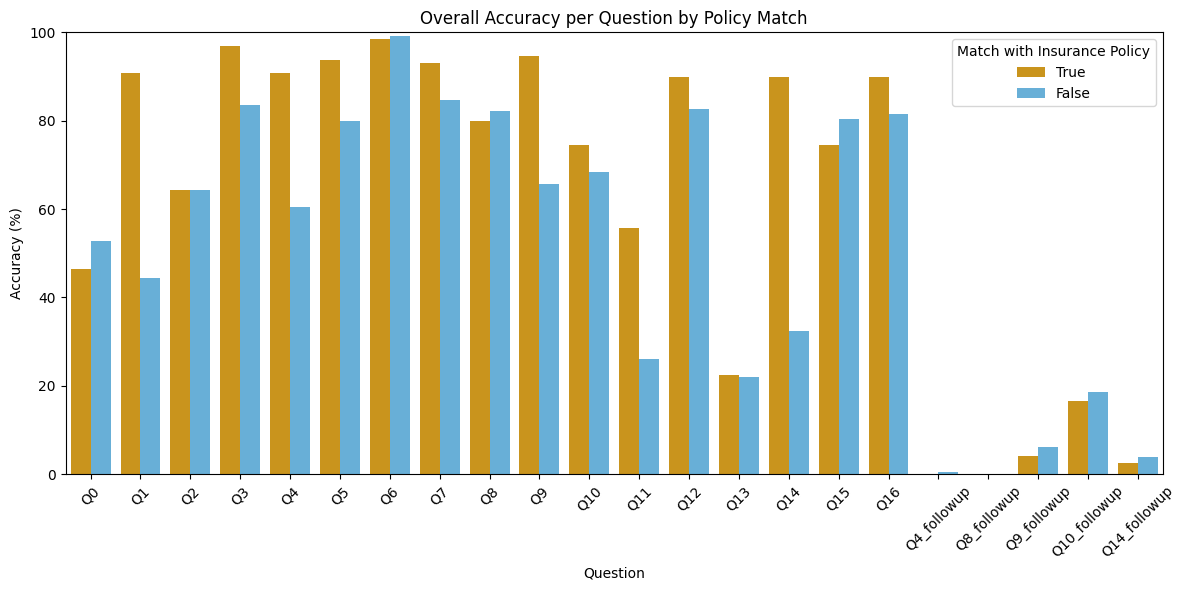

In [77]:
match_colors = {True: "#E69F00", False: "#56B4E9"}  # True: 노랑, False: 파랑
match_order = [True, False]

# 전처리
df_all = df_clean[df_clean["Score"].notna()].copy()
df_all["correct"] = df_all["Score"] == 1

# Accuracy 계산
question_level = (
    df_all
    .groupby(["Question", "match"])["correct"]
    .agg(["mean", "count"])
    .reset_index()
)
question_level["accuracy_pct"] = question_level["mean"] * 100

# 질문 순서 정렬
question_order = sorted(df_all["Question"].dropna().unique(), key=lambda x: (len(x), x))

# 시각화
plt.figure(figsize=(12, 6))
sns.barplot(
    data=question_level,
    x="Question",
    y="accuracy_pct",
    hue="match",
    hue_order=match_order,
    order=question_order,
    palette=match_colors
)
plt.xticks(rotation=45)
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.title("Overall Accuracy per Question by Policy Match")
plt.legend(title="Match with Insurance Policy")
plt.tight_layout()
plt.show()

In [79]:
df_clean.head()

,Case,Question,Predicted,Gold,Score,method,retrieval_model,qna_model,match
0,Case10,Q0,Whole Exome Sequencing (WES),Whole Exome Sequencing (WES),1,End-To-End,chatgpt,perplexity,False
1,Case10,Q1,Not specified,Yes,0,End-To-End,chatgpt,perplexity,False
2,Case10,Q2,Not specified,No,0,End-To-End,chatgpt,perplexity,False
3,Case10,Q3,No,No,1,End-To-End,chatgpt,perplexity,False
4,Case10,Q4,No,Yes,0,End-To-End,chatgpt,perplexity,False


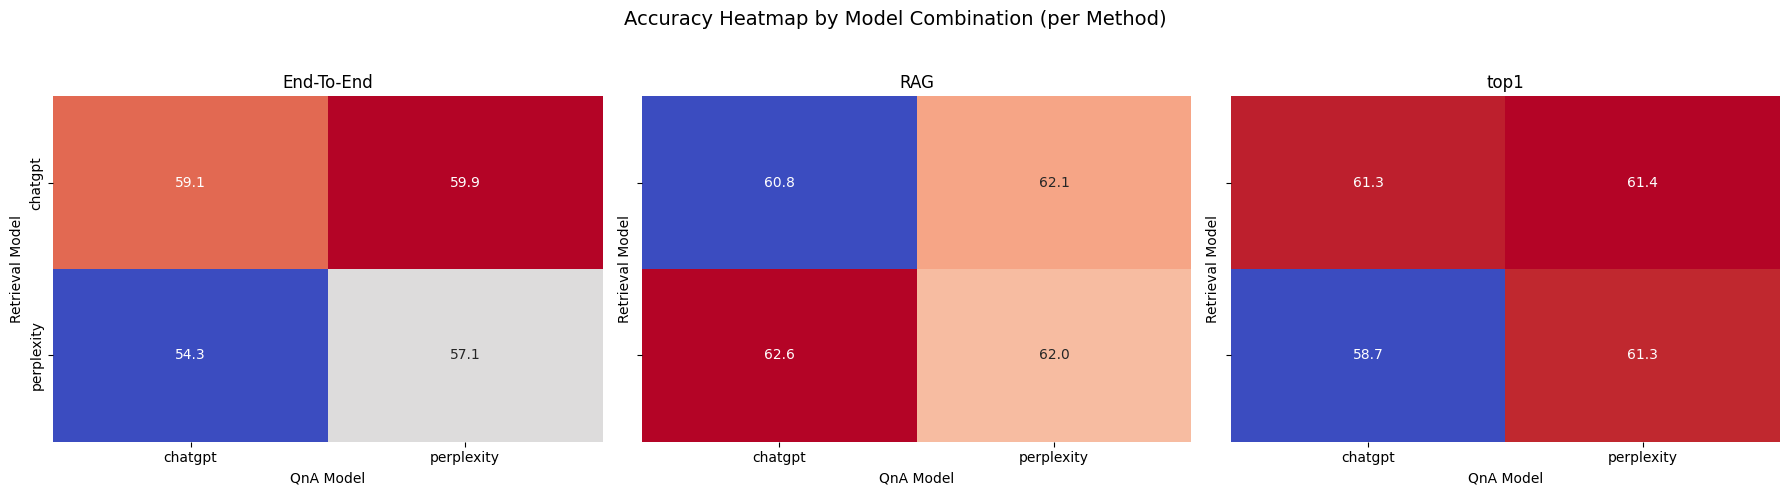

In [89]:
methods = ["End-To-End", "RAG", "top1"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, method in zip(axes, methods):
    df_method = df_clean[
        (df_clean["method"] == method) &
        (df_clean["Score"].notna())
    ].copy()

    if df_method.empty:
        ax.set_visible(False)
        continue

    df_method["correct"] = df_method["Score"] == 1
    acc = (
        df_method.groupby(["retrieval_model", "qna_model"])["correct"]
        .mean()
        .reset_index()
        .pivot(index="retrieval_model", columns="qna_model", values="correct")
    )

    if acc.empty:
        ax.set_visible(False)
        continue

    sns.heatmap(
        acc * 100,
        annot=True,
        fmt=".1f",
        cmap="coolwarm", 
        cbar=False,
        ax=ax
    )
    ax.set_title(method)
    ax.set_xlabel("QnA Model")
    ax.set_ylabel("Retrieval Model")

plt.suptitle("Accuracy Heatmap by Model Combination (per Method)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


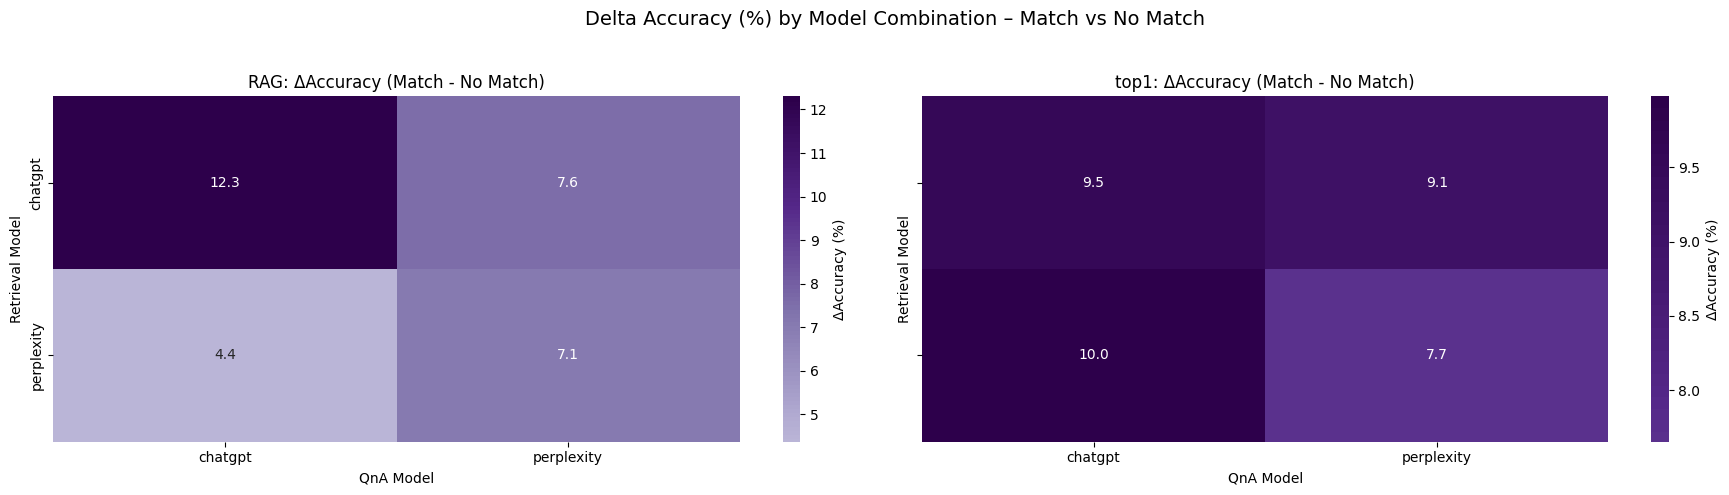

In [87]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5), sharey=True)
methods = ["RAG", "top1"]

for ax, method in zip(axes, methods):
    df_method = df_clean[
        (df_clean["method"] == method) &
        (df_clean["Score"].notna())
    ].copy()

    if df_method.empty:
        ax.set_visible(False)
        continue

    df_method["correct"] = df_method["Score"] == 1

    acc = (
        df_method.groupby(["match", "retrieval_model", "qna_model"])["correct"]
        .mean()
        .reset_index()
    )

    pivot_true = acc[acc["match"] == True].pivot(index="retrieval_model", columns="qna_model", values="correct")
    pivot_false = acc[acc["match"] == False].pivot(index="retrieval_model", columns="qna_model", values="correct")

    # Accuracy (%) 차이
    delta = (pivot_true - pivot_false) * 100

    if delta.empty:
        ax.set_visible(False)
        continue

    sns.heatmap(
        delta,
        annot=True,
        fmt=".1f",
        cmap="PuOr",
        center=0,
        cbar_kws={"label": "ΔAccuracy (%)"},
        ax=ax
    )
    ax.set_title(f"{method}: ΔAccuracy (Match - No Match)")
    ax.set_xlabel("QnA Model")
    ax.set_ylabel("Retrieval Model")

plt.suptitle("Delta Accuracy (%) by Model Combination – Match vs No Match", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


/tmp/ipykernel_47930/3159581814.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/ipykernel_47930/3159581814.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/ipykernel_47930/3159581814.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


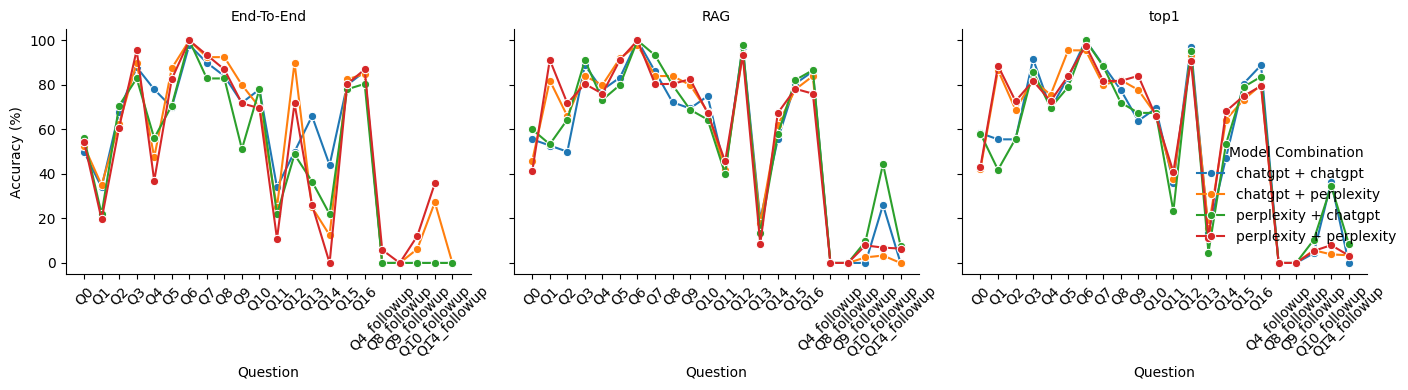

In [91]:
df_line = df_clean[df_clean["Score"].notna()].copy()
df_line["correct"] = df_line["Score"] == 1

# 질문 순서 정렬
question_order = sorted(df_line["Question"].dropna().unique(), key=lambda x: (len(x), x))

# 그룹화: 질문별, 조합별 정확도
line_data = (
    df_line.groupby(["method", "retrieval_model", "qna_model", "Question"])["correct"]
    .mean()
    .reset_index()
)
line_data["accuracy_pct"] = line_data["correct"] * 100
line_data["Question"] = pd.Categorical(line_data["Question"], categories=question_order, ordered=True)
line_data["model_combo"] = line_data["retrieval_model"] + " + " + line_data["qna_model"]

# Plot
g = sns.FacetGrid(
    data=line_data,
    col="method",
    col_wrap=3,
    height=4,
    sharey=True
)

g.map_dataframe(
    sns.lineplot,
    x="Question",
    y="accuracy_pct",
    hue="model_combo",
    marker="o"
)

g.set_axis_labels("Question", "Accuracy (%)")
g.add_legend(title="Model Combination")
g.set_titles("{col_name}")
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()

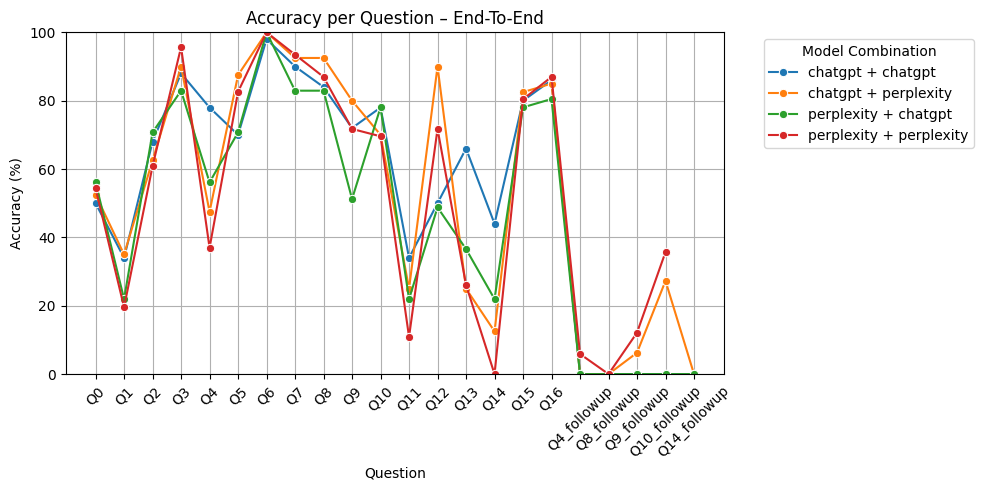

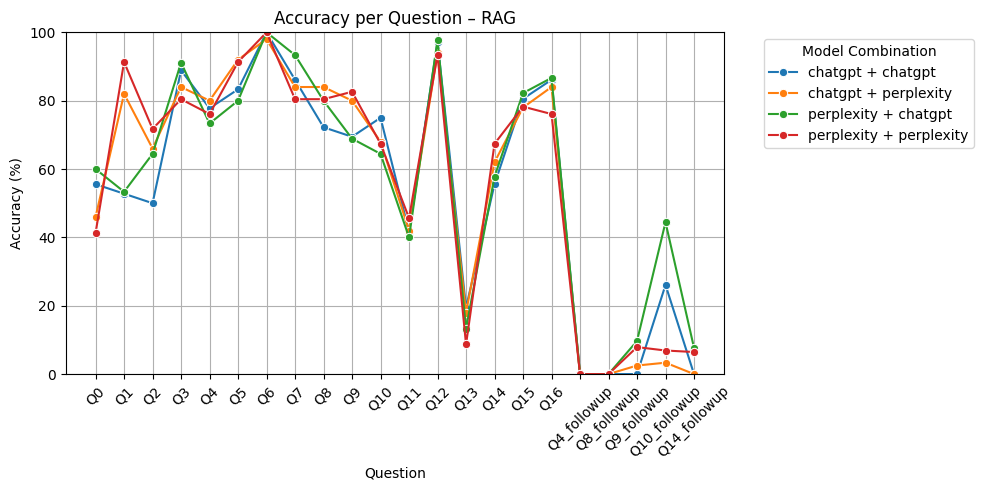

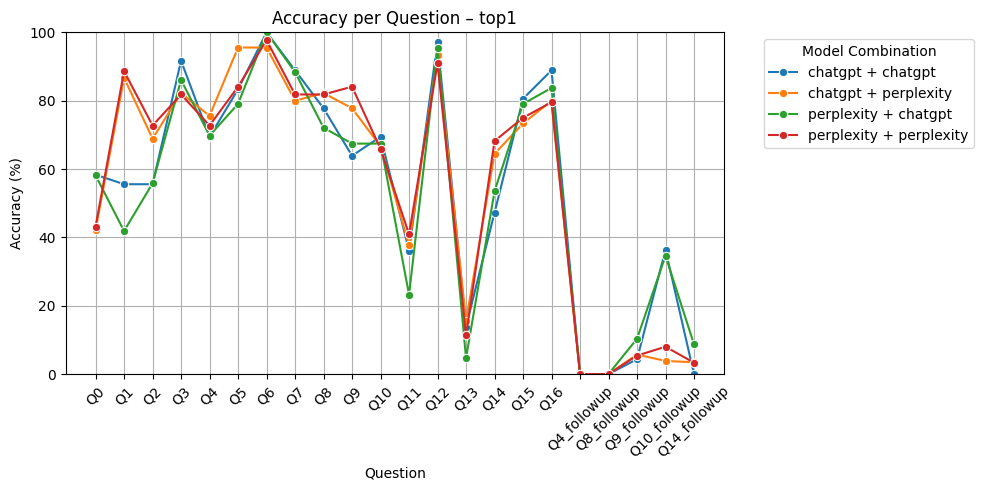

In [92]:
df_line = df_clean[df_clean["Score"].notna()].copy()
df_line["correct"] = df_line["Score"] == 1

# 질문 순서 정렬
question_order = sorted(df_line["Question"].dropna().unique(), key=lambda x: (len(x), x))

# 정확도 계산
line_data = (
    df_line.groupby(["method", "retrieval_model", "qna_model", "Question"])["correct"]
    .mean()
    .reset_index()
)
line_data["accuracy_pct"] = line_data["correct"] * 100
line_data["Question"] = pd.Categorical(line_data["Question"], categories=question_order, ordered=True)
line_data["model_combo"] = line_data["retrieval_model"] + " + " + line_data["qna_model"]

# 방법론별로 한 그래프씩
methods = ["End-To-End", "RAG", "top1"]

for method in methods:
    plt.figure(figsize=(10, 5))
    df_plot = line_data[line_data["method"] == method]
    sns.lineplot(
        data=df_plot,
        x="Question",
        y="accuracy_pct",
        hue="model_combo",
        marker="o"
    )
    plt.title(f"Accuracy per Question – {method}")
    plt.ylim(0, 100)
    plt.ylabel("Accuracy (%)")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Model Combination", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

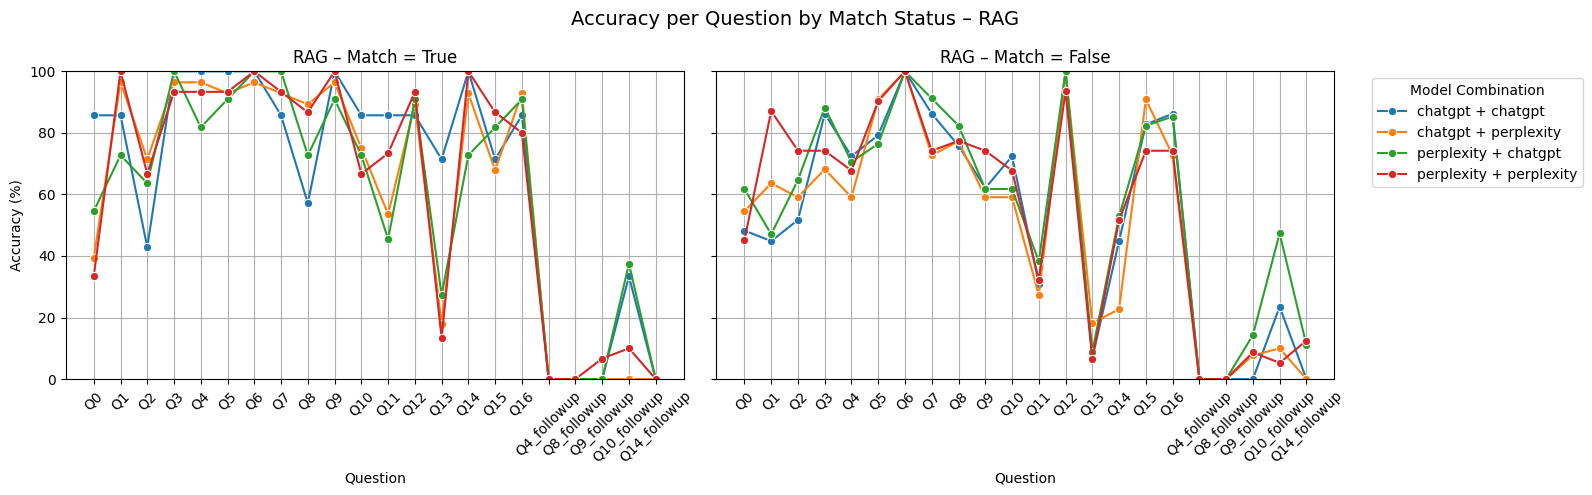

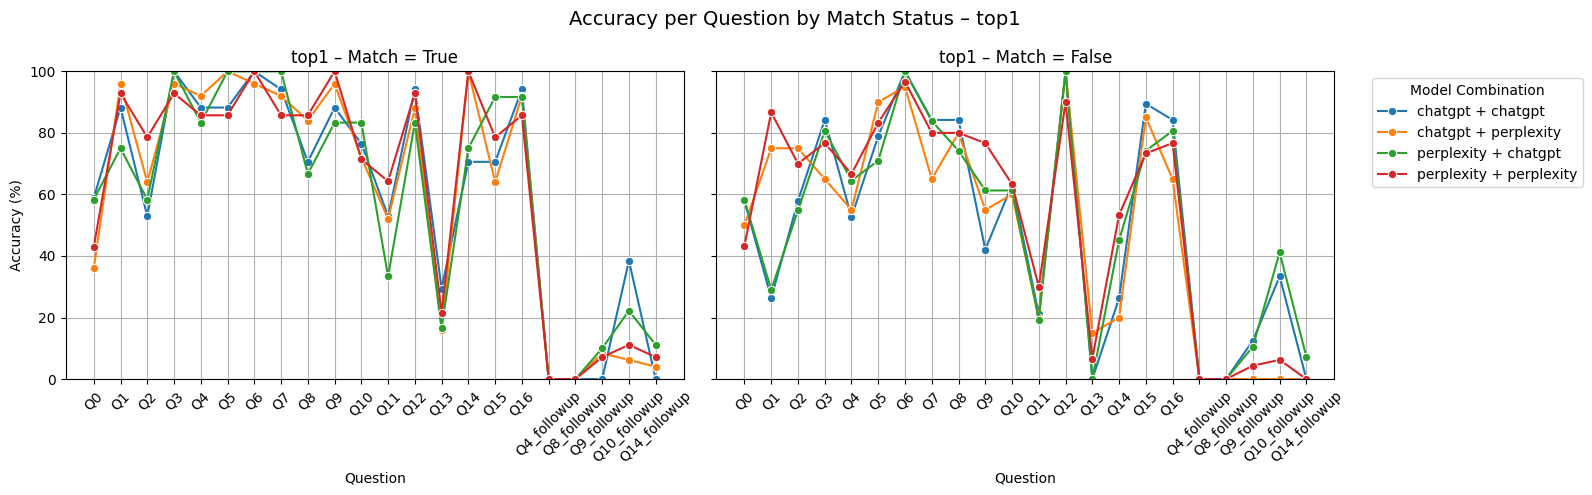

In [94]:
df_line = df_clean[df_clean["Score"].notna()].copy()
df_line["correct"] = df_line["Score"] == 1

# 질문 순서 고정
question_order = sorted(df_line["Question"].dropna().unique(), key=lambda x: (len(x), x))

# 정확도 계산
line_data = (
    df_line.groupby(["method", "match", "retrieval_model", "qna_model", "Question"])["correct"]
    .mean()
    .reset_index()
)
line_data["accuracy_pct"] = line_data["correct"] * 100
line_data["Question"] = pd.Categorical(line_data["Question"], categories=question_order, ordered=True)
line_data["model_combo"] = line_data["retrieval_model"] + " + " + line_data["qna_model"]

# Match 상태 순서 고정
match_order = [True, False]
match_labels = {True: "Match = True", False: "Match = False"}

# 방법론별로 그리기
methods = ["RAG", "top1"]

for method in methods:
    fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
    for i, match in enumerate(match_order):
        df_plot = line_data[(line_data["method"] == method) & (line_data["match"] == match)]
        sns.lineplot(
            data=df_plot,
            x="Question",
            y="accuracy_pct",
            hue="model_combo",
            marker="o",
            ax=axes[i]
        )
        axes[i].set_title(f"{method} – {match_labels[match]}")
        axes[i].set_ylim(0, 100)
        axes[i].set_ylabel("Accuracy (%)")
        axes[i].set_xlabel("Question")
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].grid(True)
        if i == 1:
            axes[i].legend(title="Model Combination", bbox_to_anchor=(1.05, 1), loc="upper left")
        else:
            if axes[i].legend_ is not None:
                axes[i].legend_.remove()
    plt.suptitle(f"Accuracy per Question by Match Status – {method}", fontsize=14)
    plt.tight_layout()
    plt.show()


In [101]:
df_clean.head()

,Case,Question,Predicted,Gold,Score,method,retrieval_model,qna_model,match
0,Case10,Q0,Whole Exome Sequencing (WES),Whole Exome Sequencing (WES),1,End-To-End,chatgpt,perplexity,False
1,Case10,Q1,Not specified,Yes,0,End-To-End,chatgpt,perplexity,False
2,Case10,Q2,Not specified,No,0,End-To-End,chatgpt,perplexity,False
3,Case10,Q3,No,No,1,End-To-End,chatgpt,perplexity,False
4,Case10,Q4,No,Yes,0,End-To-End,chatgpt,perplexity,False


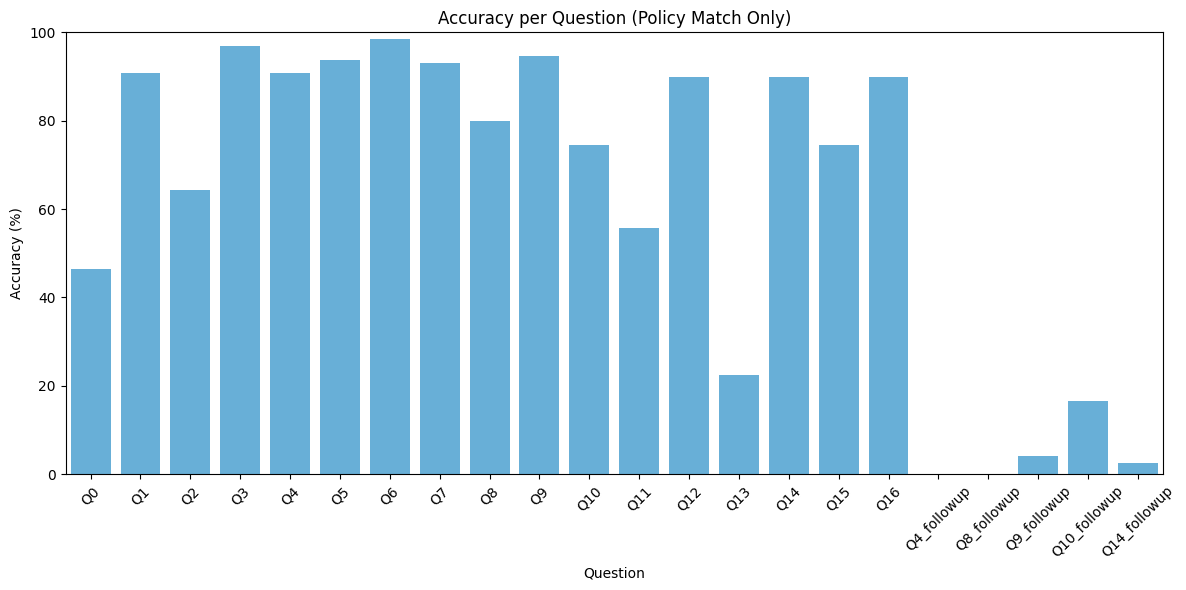

In [100]:
match_colors = {True: "#56B4E9"}
match_order = [True]

# 전처리
df_all = df_clean[df_clean["Score"].notna()].copy()
df_all["correct"] = df_all["Score"] == 1

# Match = True만 필터링
question_level = (
    df_all[df_all["match"] == True]
    .groupby(["Question", "match"])["correct"]
    .agg(["mean", "count"])
    .reset_index()
)
question_level["accuracy_pct"] = question_level["mean"] * 100

# 질문 순서 정렬
question_order = sorted(df_all["Question"].dropna().unique(), key=lambda x: (len(x), x))

# 시각화
plt.figure(figsize=(12, 6))
sns.barplot(
    data=question_level,
    x="Question",
    y="accuracy_pct",
    hue="match",  # hue는 있어야 색상 매핑 가능
    hue_order=match_order,
    order=question_order,
    palette=match_colors
)

plt.xticks(rotation=45)
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.title("Accuracy per Question (Policy Match Only)")

# ✅ Legend 제거
plt.legend().remove()

plt.tight_layout()
plt.show()


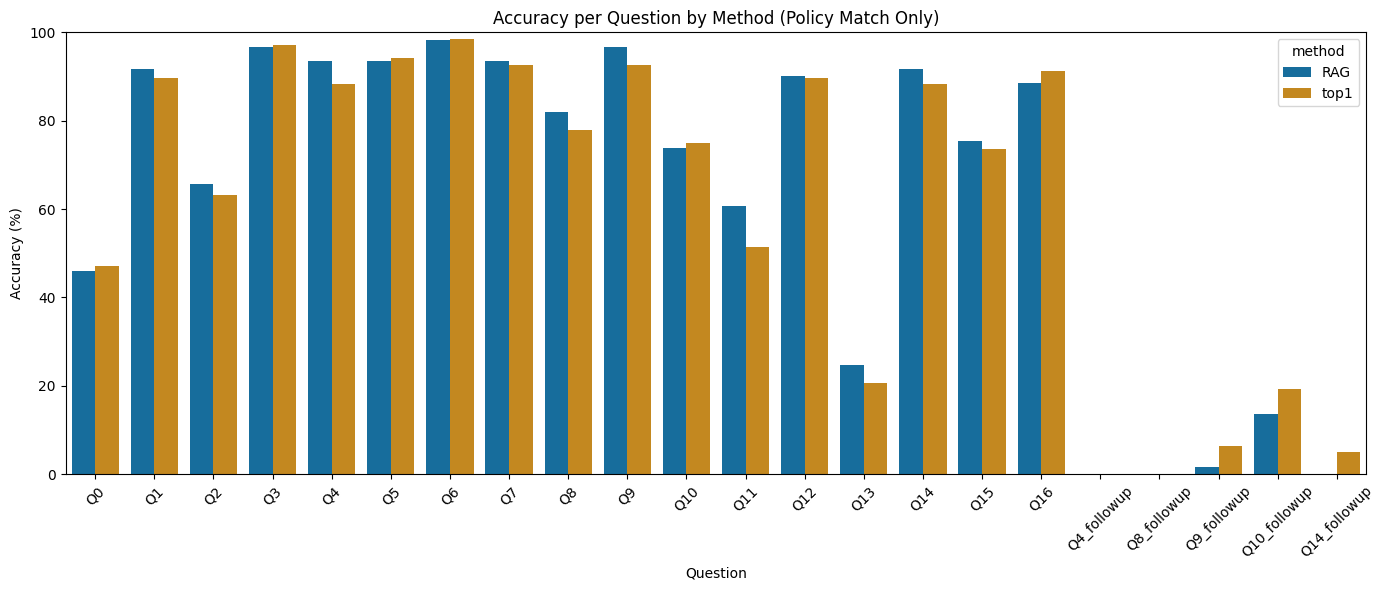

In [102]:
df_model = df_clean[(df_clean["Score"].notna()) & (df_clean["match"] == True)].copy()
df_model["correct"] = df_model["Score"] == 1

# 질문별, 방법론별 정확도 계산
question_method_summary = (
    df_model.groupby(["Question", "method"])["correct"]
    .agg(["mean", "count"])
    .reset_index()
)
question_method_summary["accuracy_pct"] = question_method_summary["mean"] * 100

# 질문 순서 정렬
question_order = sorted(
    question_method_summary["Question"].dropna().unique(),
    key=lambda x: (len(x), x)
)

# 시각화
plt.figure(figsize=(14, 6))
sns.barplot(
    data=question_method_summary,
    x="Question",
    y="accuracy_pct",
    hue="method",
    order=question_order,
    palette="colorblind"
)
plt.xticks(rotation=45)
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.title("Accuracy per Question by Method (Policy Match Only)")
plt.tight_layout()
plt.show()

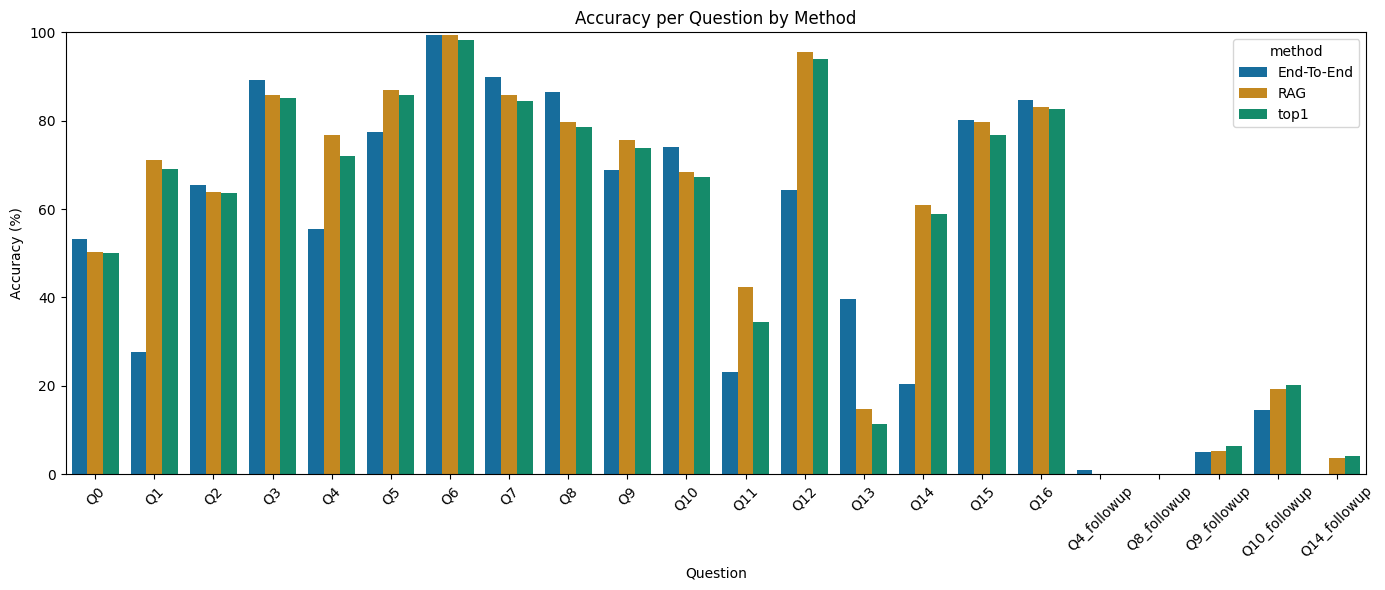

In [103]:
df_model = df_clean[(df_clean["Score"].notna()).copy()]
df_model["correct"] = df_model["Score"] == 1

# 질문별, 방법론별 정확도 계산
question_method_summary = (
    df_model.groupby(["Question", "method"])["correct"]
    .agg(["mean", "count"])
    .reset_index()
)
question_method_summary["accuracy_pct"] = question_method_summary["mean"] * 100

# 질문 순서 정렬
question_order = sorted(
    question_method_summary["Question"].dropna().unique(),
    key=lambda x: (len(x), x)
)

# 시각화
plt.figure(figsize=(14, 6))
sns.barplot(
    data=question_method_summary,
    x="Question",
    y="accuracy_pct",
    hue="method",
    order=question_order,
    palette="colorblind"
)
plt.xticks(rotation=45)
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.title("Accuracy per Question by Method")
plt.tight_layout()
plt.show()

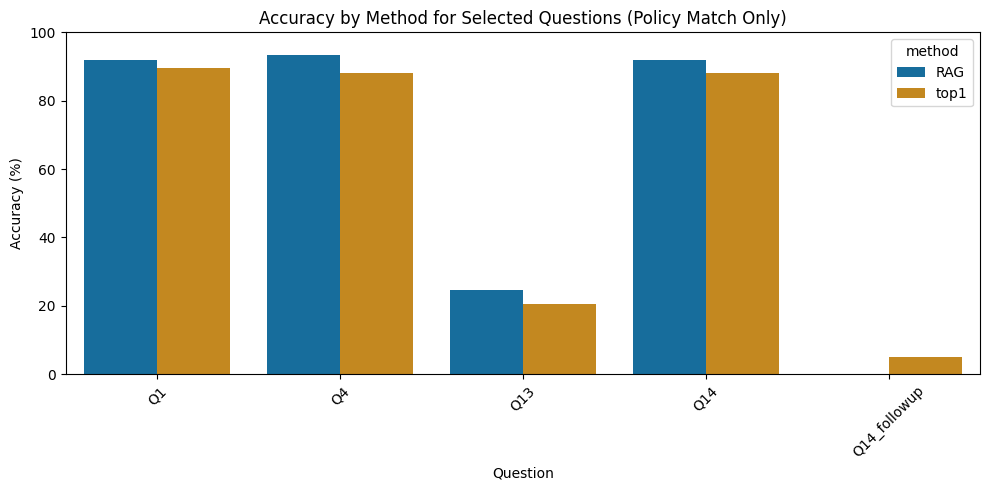

In [104]:
selected_questions = ["Q1", "Q4", "Q13", "Q14", "Q14_followup"]

# 데이터 전처리
df_selected = df_clean[
    (df_clean["Score"].notna()) &
    (df_clean["match"] == True) &
    (df_clean["Question"].isin(selected_questions))
].copy()

df_selected["correct"] = df_selected["Score"] == 1

# 정확도 계산
accuracy_summary = (
    df_selected.groupby(["Question", "method"])["correct"]
    .agg(["mean", "count"])
    .reset_index()
)
accuracy_summary["accuracy_pct"] = accuracy_summary["mean"] * 100

# 질문 순서 정렬
question_order = selected_questions

# 시각화
plt.figure(figsize=(10, 5))
sns.barplot(
    data=accuracy_summary,
    x="Question",
    y="accuracy_pct",
    hue="method",
    order=question_order,
    palette="colorblind"
)
plt.ylim(0, 100)
plt.ylabel("Accuracy (%)")
plt.title("Accuracy by Method for Selected Questions (Policy Match Only)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

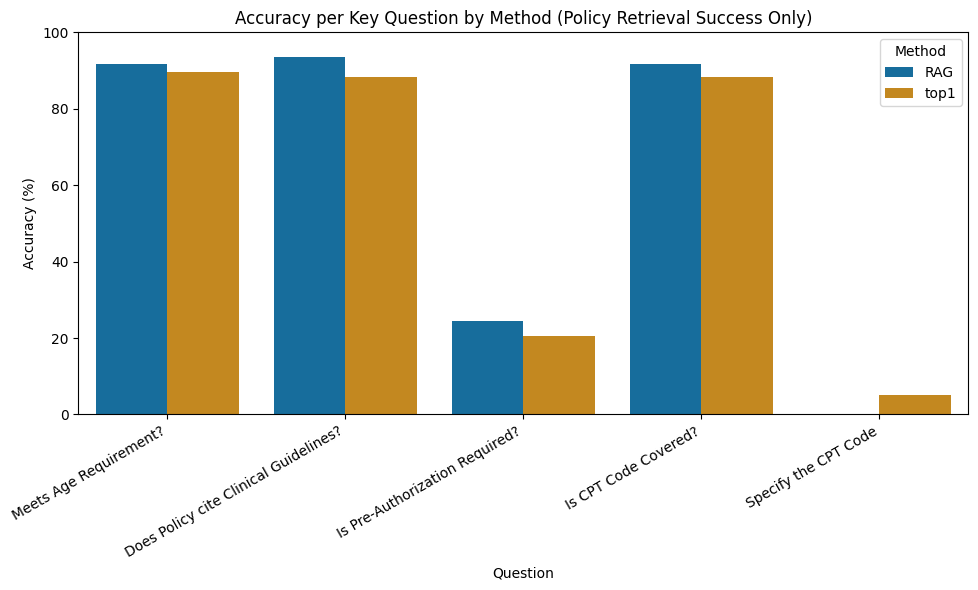

In [110]:
# 라벨 매핑
label_map = {
    "Q1": "Meets Age Requirement?",
    "Q4": "Does Policy cite Clinical Guidelines?",
    "Q13": "Is Pre-Authorization Required?",
    "Q14": "Is CPT Code Covered?",
    "Q14_followup": "Specify the CPT Code"
}

# 질문 ID 및 표시 순서
selected_questions = ["Q1", "Q4", "Q13", "Q14", "Q14_followup"]  # 순서 조정됨
x_labels = [label_map[q] for q in selected_questions]

# 필터링 및 정확도 계산
df_all = df_clean[df_clean["Score"].notna()].copy()
df_all["correct"] = df_all["Score"] == 1
df_plot = df_all[
    (df_all["match"] == True) &
    (df_all["Question"].isin(selected_questions))
].copy()

acc_summary = (
    df_plot.groupby(["Question", "method"])["correct"]
    .mean()
    .reset_index()
)
acc_summary["accuracy_pct"] = acc_summary["correct"] * 100
acc_summary["label"] = acc_summary["Question"].map(label_map)

# x축 순서 강제 정렬
acc_summary["label"] = pd.Categorical(acc_summary["label"], categories=x_labels, ordered=True)

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(
    data=acc_summary,
    x="label",
    y="accuracy_pct",
    hue="method",
    palette="colorblind"
)
plt.ylabel("Accuracy (%)")
plt.xlabel("Question")
plt.ylim(0, 100)
plt.xticks(rotation=30, ha="right")
plt.title("Accuracy per Key Question by Method (Policy Retrieval Success Only)")

# ✅ Legend 바깥으로 이동
plt.legend(title="Method", loc="upper right")

plt.tight_layout()
plt.show()

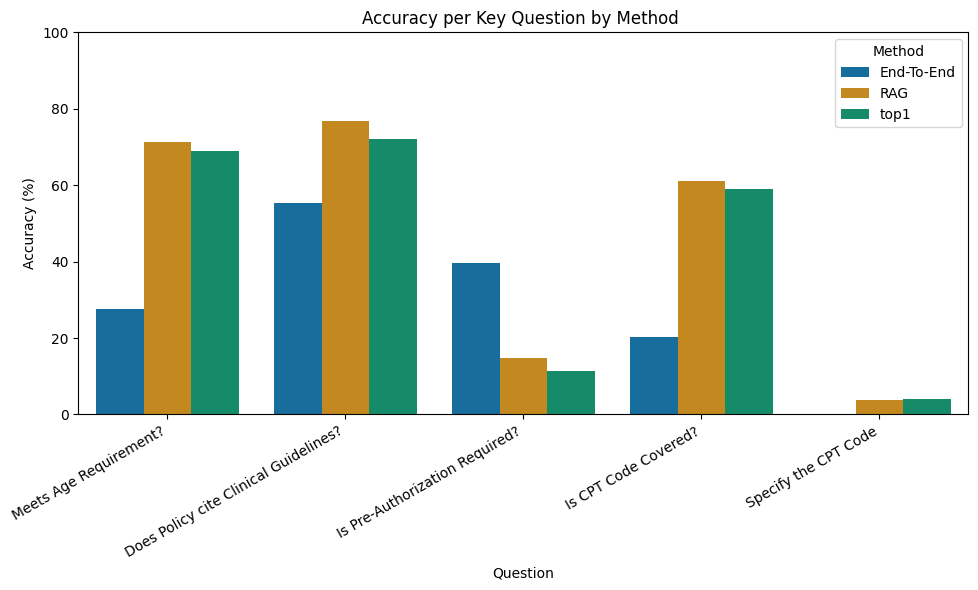

In [111]:
# 라벨 매핑
label_map = {
    "Q1": "Meets Age Requirement?",
    "Q4": "Does Policy cite Clinical Guidelines?",
    "Q13": "Is Pre-Authorization Required?",
    "Q14": "Is CPT Code Covered?",
    "Q14_followup": "Specify the CPT Code"
}

# 질문 ID 및 표시 순서
selected_questions = ["Q1", "Q4", "Q13", "Q14", "Q14_followup"]  # 순서 조정됨
x_labels = [label_map[q] for q in selected_questions]

# 필터링 및 정확도 계산
df_all = df_clean[df_clean["Score"].notna()].copy()
df_all["correct"] = df_all["Score"] == 1
df_plot = df_all[
    (df_all["Question"].isin(selected_questions))
].copy()

acc_summary = (
    df_plot.groupby(["Question", "method"])["correct"]
    .mean()
    .reset_index()
)
acc_summary["accuracy_pct"] = acc_summary["correct"] * 100
acc_summary["label"] = acc_summary["Question"].map(label_map)

# x축 순서 강제 정렬
acc_summary["label"] = pd.Categorical(acc_summary["label"], categories=x_labels, ordered=True)

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(
    data=acc_summary,
    x="label",
    y="accuracy_pct",
    hue="method",
    palette="colorblind"
)
plt.ylabel("Accuracy (%)")
plt.xlabel("Question")
plt.ylim(0, 100)
plt.xticks(rotation=30, ha="right")
plt.title("Accuracy per Key Question by Method ")

# ✅ Legend 바깥으로 이동
plt.legend(title="Method", loc="upper right")

plt.tight_layout()
plt.show()

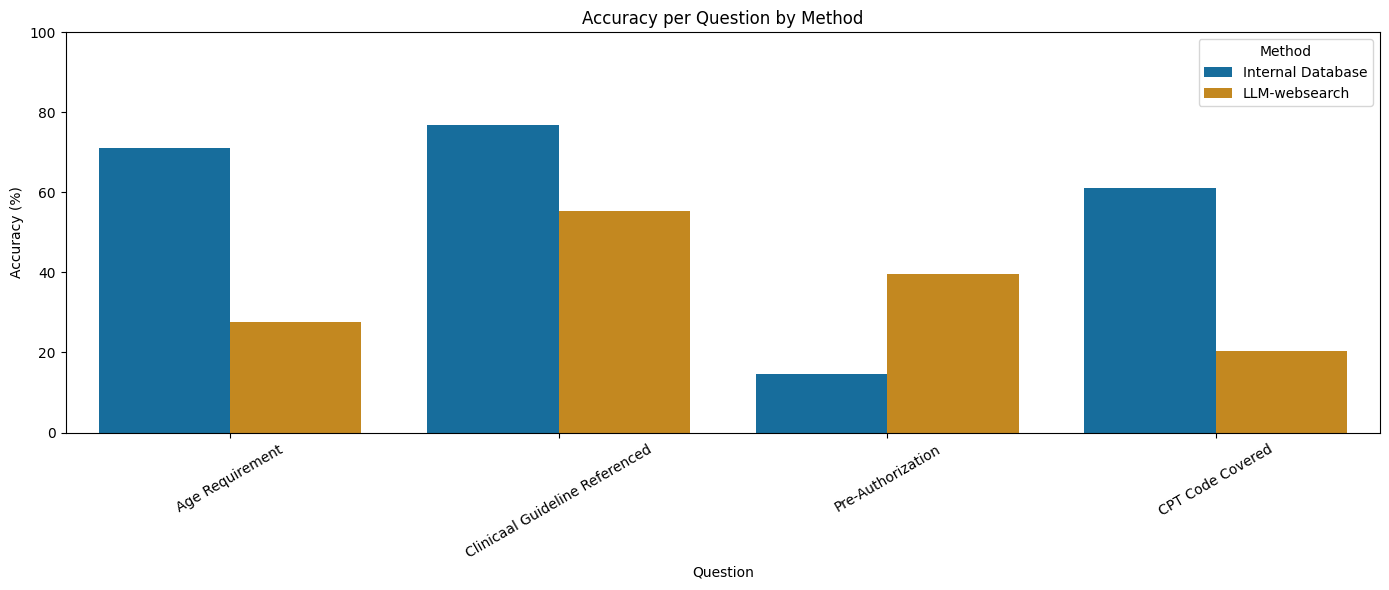

In [116]:
# 방법론 이름 매핑
method_label_map = {
    "End-To-End": "LLM-websearch",
    "RAG": "Internal Database"
}

# 질문 ID → 간결한 라벨로 매핑
label_map = {
    "Q1": "Age Requirement",
    "Q4": "Clinicaal Guideline Referenced",
    "Q13": "Pre-Authorization",
    "Q14": "CPT Code Covered"
}

# 필터링 및 전처리
df_model = df_clean[
    (df_clean["Score"].notna()) &
    (df_clean["method"].isin(method_label_map.keys()))
].copy()

df_model["correct"] = df_model["Score"] == 1
df_model["method"] = df_model["method"].map(method_label_map)

# 정확도 계산
question_method_summary = (
    df_model.groupby(["Question", "method"])["correct"]
    .agg(["mean", "count"])
    .reset_index()
)
question_method_summary["accuracy_pct"] = question_method_summary["mean"] * 100
question_method_summary["Question"] = question_method_summary["Question"].map(label_map)

# 질문 순서
question_order = [label_map[q] for q in ["Q1", "Q4", "Q13", "Q14"]]

# 시각화
plt.figure(figsize=(14, 6))
sns.barplot(
    data=question_method_summary,
    x="Question",
    y="accuracy_pct",
    hue="method",
    order=question_order,
    palette="colorblind"
)
plt.xticks(rotation=30)
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.title("Accuracy per Question by Method")
plt.legend(title="Method", loc="upper right")
plt.tight_layout()
plt.show()


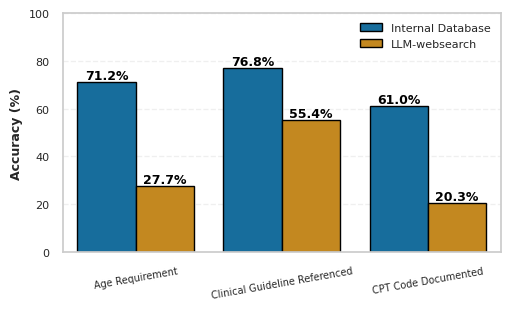

In [127]:
label_map = {
    "Q1": "Age Requirement",
    "Q4": "Clinical Guideline Referenced", 
    "Q14": "CPT Code Documented"
}

df_model = df_clean[
    (df_clean["Score"].notna()) &
    (df_clean["method"].isin(method_label_map.keys()))
].copy()

df_model["correct"] = df_model["Score"] == 1
df_model["method"] = df_model["method"].map(method_label_map)

# 정확도 계산
question_method_summary = (
    df_model.groupby(["Question", "method"])["correct"]
    .agg(["mean", "count"])
    .reset_index()
)
question_method_summary["accuracy_pct"] = question_method_summary["mean"] * 100
question_method_summary["Question"] = question_method_summary["Question"].map(label_map)


question_order = [label_map[q] for q in ["Q1", "Q4", "Q14"]]

plt.figure(figsize=(5, 3))
sns.set_theme(style="whitegrid", font_scale=0.9)

barplot = sns.barplot(
    data=question_method_summary,
    x="Question",
    y="accuracy_pct",
    hue="method",
    order=question_order,
    palette="colorblind",
    edgecolor="black"
)

# 바 위에 정확도 표기
for p in barplot.patches:
    height = p.get_height()
    if not np.isnan(height) and height != 0:
        barplot.annotate(f'{height:.1f}%',
                         (p.get_x() + p.get_width() / 2, height),
                         ha='center', va='bottom',
                         fontsize=9, color='black', fontweight='bold')


plt.xticks(rotation=10, ha='center', fontsize=7)
plt.yticks(fontsize=8)
plt.ylabel("Accuracy (%)", fontsize=9, weight='bold')
plt.xlabel("") 
plt.ylim(0, 100)
plt.yticks(np.arange(0, 101, 20))
handles, labels = barplot.get_legend_handles_labels()
plt.legend(handles=handles, labels=labels, title="", fontsize=8, loc="upper right", frameon=False)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout(pad=0.3)
plt.show()